# DistilBERT Baseline

Fine-tune and evaluate a DistilBERT classifier for toxic comment detection.

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
import json
import sys
import torch
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

DATA_DIR = Path("../../data")
MODEL_DIR = DATA_DIR / "models/transformer"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

sys.path.insert(0, str(Path("../.." ).resolve()))

## 2. Load Data

In [2]:
df = pd.read_csv(DATA_DIR / "train_dataset.csv")
print(f"Total samples: {len(df)}")
print(f"Toxicity rate: {df['y'].mean():.2%}")

Total samples: 470322
Toxicity rate: 19.86%


## 3. Train/Test Split

In [3]:
X = df['text'].values
y = df['y'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 376257, Test: 94065


## 4. Fine-tune

In [4]:
from model import TransformerClassifier
from tqdm.auto import tqdm

clf = TransformerClassifier(
    model_name="distilbert-base-uncased",
    max_length=128,
    batch_size=64
)

clf.fit(
    X_train.tolist(), y_train,
    epochs=3, batch_size=64, lr=2e-5
)

Device: mps


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch 1/3:   0%|          | 0/5880 [00:00<?, ?it/s]

Epoch 1/3 done  avg_loss=0.1976


Epoch 2/3:   0%|          | 0/5880 [00:00<?, ?it/s]

Epoch 2/3 done  avg_loss=0.1120


Epoch 3/3:   0%|          | 0/5880 [00:00<?, ?it/s]

Epoch 3/3 done  avg_loss=0.0868


## 5. Evaluate

              precision    recall  f1-score   support

        Safe       0.97      0.98      0.97     75381
       Toxic       0.90      0.89      0.90     18684

    accuracy                           0.96     94065
   macro avg       0.94      0.93      0.94     94065
weighted avg       0.96      0.96      0.96     94065



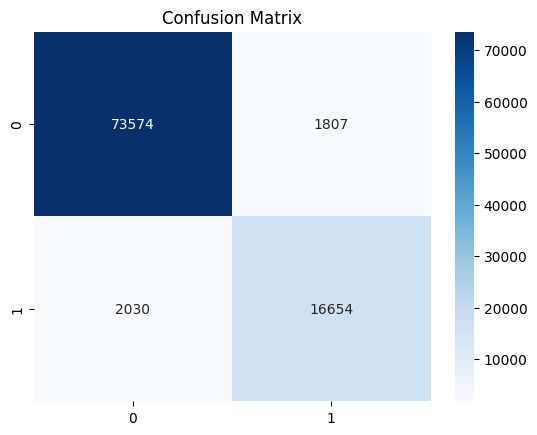

In [5]:
y_pred = clf.predict(X_test.tolist())
print(classification_report(y_test, y_pred, target_names=['Safe', 'Toxic']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## 6. Save Model

In [ ]:
clf.save(str(MODEL_DIR))

with open(MODEL_DIR / "test_data.pkl", 'wb') as f:
    pickle.dump({'X_test': X_test, 'y_test': y_test}, f)

print("Models saved!")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Transformer model saved to ../../data/models/transformer
Models saved!


## 7. Load Model Using Our Classes

In [7]:
import importlib
if 'model' in sys.modules:
    importlib.reload(sys.modules['model.models'])
    importlib.reload(sys.modules['model'])

from model import TransformerClassifier

loaded_model = TransformerClassifier(model_dir=str(MODEL_DIR))

test_texts = ["You are stupid", "Have a nice day"]
predictions = loaded_model.predict(test_texts)
probas = loaded_model.predict_proba(test_texts)

print("Test predictions:")
for text, pred, proba in zip(test_texts, predictions, probas):
    print(f"  '{text}' -> {pred} (prob: {proba[1]:.3f})")

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Transformer model loaded from ../../data/models/transformer (device: mps)
Test predictions:
  'You are stupid' -> 1 (prob: 0.996)
  'Have a nice day' -> 0 (prob: 0.002)


## 8. Comprehensive Evaluation with get_metrics()

In [8]:
eval_size = 1000
X_test_subset = X_test[:eval_size].tolist()
y_test_subset = y_test[:eval_size]

results = loaded_model.get_metrics(
    X_test_subset,
    y_test_subset,
    n_latency_runs=50
)

print("=" * 60)
print("EVALUATION RESULTS")
print("=" * 60)

print("\nQuality Metrics:")
for metric, value in results['quality'].items():
    print(f"  {metric:15s}: {value:.4f}")

print(f"\nConfusion Matrix:")
cm_array = np.array(results['confusion_matrix'])
print(f"  [[TN={cm_array[0,0]:5d}, FP={cm_array[0,1]:5d}]")
print(f"   [FN={cm_array[1,0]:5d}, TP={cm_array[1,1]:5d}]]")

print(f"\nLatency Metrics:")
for metric, value in results['latency'].items():
    print(f"  {metric:20s}: {value:.4f}")

print(f"\nThroughput: {results['throughput_samples_per_sec']:.2f} samples/sec")
print(f"Peak Memory: {results['peak_memory_mb']:.2f} MB")

EVALUATION RESULTS

Quality Metrics:
  precision      : 0.9082
  recall         : 0.8725
  f1_score       : 0.8900
  pr_auc         : 0.9533

Confusion Matrix:
  [[TN=  778, FP=   18]
   [FN=   26, TP=  178]]

Latency Metrics:
  latency_mean_ms     : 3.0811
  latency_std_ms      : 0.1146
  latency_min_ms      : 2.8209
  latency_max_ms      : 3.3319

Throughput: 334.36 samples/sec
Peak Memory: 0.05 MB


## 9. Visualize Performance Metrics

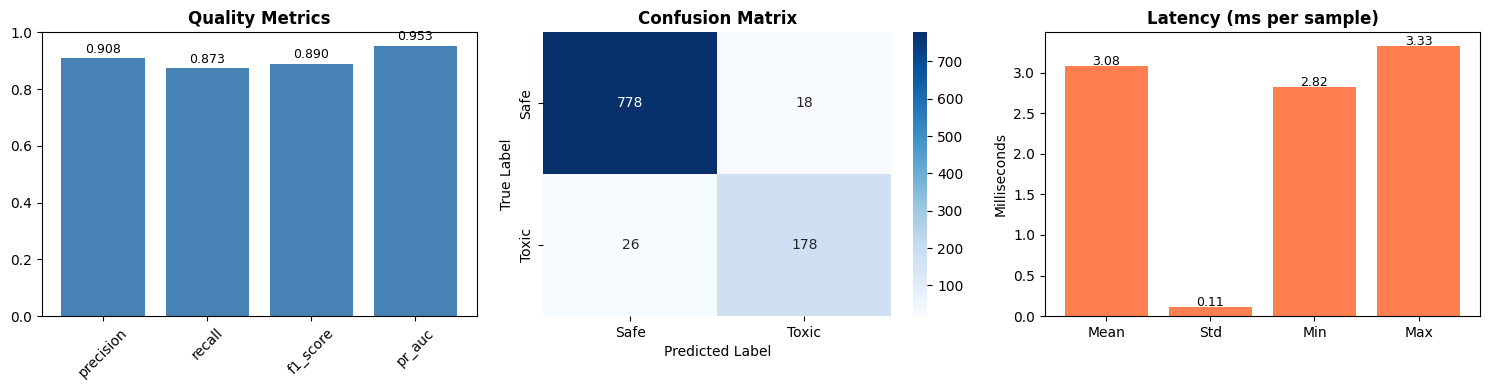


Model Summary:
  Throughput: 334 samples/sec
  Avg Latency: 3.08 ms/sample
  F1 Score: 0.8900


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

quality_data = results['quality']
axes[0].bar(quality_data.keys(), quality_data.values(), color='steelblue')
axes[0].set_title('Quality Metrics', fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=45)
for i, (k, v) in enumerate(quality_data.items()):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

cm_array = np.array(results['confusion_matrix'])
sns.heatmap(cm_array, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Safe', 'Toxic'], yticklabels=['Safe', 'Toxic'])
axes[1].set_title('Confusion Matrix', fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

latency_data = results['latency']
latency_values = [latency_data['latency_mean_ms'], latency_data['latency_std_ms'],
                  latency_data['latency_min_ms'], latency_data['latency_max_ms']]
latency_labels = ['Mean', 'Std', 'Min', 'Max']
axes[2].bar(latency_labels, latency_values, color='coral')
axes[2].set_title('Latency (ms per sample)', fontweight='bold')
axes[2].set_ylabel('Milliseconds')
for i, v in enumerate(latency_values):
    axes[2].text(i, v + 0.01, f'{v:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nModel Summary:")
print(f"  Throughput: {results['throughput_samples_per_sec']:.0f} samples/sec")
print(f"  Avg Latency: {latency_data['latency_mean_ms']:.2f} ms/sample")
print(f"  F1 Score: {quality_data['f1_score']:.4f}")

## 10. Save Evaluation Results

In [10]:
results_path = MODEL_DIR / "evaluation_results.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Evaluation results saved to {results_path}")

Evaluation results saved to ../../data/models/transformer/evaluation_results.json
